In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 1000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/06 16:13:48
episode : 0 | final step : 99 | total reward : -128.0
2020/10/06 16:13:49
episode : 1 | final step : 98 | total reward : -71.0
2020/10/06 16:13:50
episode : 2 | final step : 98 | total reward : -53.0
2020/10/06 16:13:51
episode : 3 | final step : 99 | total reward : -50.0
2020/10/06 16:13:52
episode : 4 | final step : 97 | total reward : -51.0
2020/10/06 16:13:53
episode : 5 | final step : 98 | total reward : -50.0
2020/10/06 16:13:54
episode : 6 | final step : 97 | total reward : -53.0
2020/10/06 16:13:55
episode : 7 | final step : 98 | total reward : -51.0
2020/10/06 16:13:56
episode : 8 | final step : 97 | total reward : 50.0
2020/10/06 16:13:57
episode : 9 | final step : 98 | total reward : -50.0
2020/10/06 16:13:58
episode : 10 | final step : 98 | total reward : -50.0
2020/10/06 16:13:59
episode : 11 | final step : 98 | total reward : -51.0
2020/10/06 16:14:00
episode : 12 | final step : 100 | total reward : -53.0
2020/10/06 16:14:01
episode : 13 | final step :

2020/10/06 16:15:43
episode : 113 | final step : 95 | total reward : 6.0
2020/10/06 16:15:44
episode : 114 | final step : 99 | total reward : 2.0
2020/10/06 16:15:45
episode : 115 | final step : 99 | total reward : 2.0
2020/10/06 16:15:46
episode : 116 | final step : 94 | total reward : 7.0
2020/10/06 16:15:47
episode : 117 | final step : 96 | total reward : 5.0
2020/10/06 16:15:48
episode : 118 | final step : 100 | total reward : 1.0
2020/10/06 16:15:49
episode : 119 | final step : 99 | total reward : 2.0
2020/10/06 16:15:50
episode : 120 | final step : 97 | total reward : 4.0
2020/10/06 16:15:51
episode : 121 | final step : 96 | total reward : 5.0
2020/10/06 16:15:52
episode : 122 | final step : 100 | total reward : 1.0
2020/10/06 16:15:53
episode : 123 | final step : 100 | total reward : 1.0
2020/10/06 16:15:54
episode : 124 | final step : 96 | total reward : 5.0
2020/10/06 16:15:55
episode : 125 | final step : 100 | total reward : 1.0
2020/10/06 16:15:56
episode : 126 | final step 

2020/10/06 16:17:40
episode : 225 | final step : 99 | total reward : 2.0
2020/10/06 16:17:41
episode : 226 | final step : 96 | total reward : 5.0
2020/10/06 16:17:42
episode : 227 | final step : 98 | total reward : 3.0
2020/10/06 16:17:43
episode : 228 | final step : 94 | total reward : 7.0
2020/10/06 16:17:44
episode : 229 | final step : 95 | total reward : 6.0
2020/10/06 16:17:45
episode : 230 | final step : 98 | total reward : 3.0
2020/10/06 16:17:46
episode : 231 | final step : 98 | total reward : 3.0
2020/10/06 16:17:47
episode : 232 | final step : 99 | total reward : 2.0
2020/10/06 16:17:48
episode : 233 | final step : 94 | total reward : 7.0
2020/10/06 16:17:49
episode : 234 | final step : 100 | total reward : 1.0
2020/10/06 16:17:50
episode : 235 | final step : 98 | total reward : 3.0
2020/10/06 16:17:51
episode : 236 | final step : 96 | total reward : 5.0
2020/10/06 16:17:52
episode : 237 | final step : 94 | total reward : 7.0
2020/10/06 16:17:53
episode : 238 | final step : 9

2020/10/06 16:19:40
episode : 337 | final step : 97 | total reward : 4.0
2020/10/06 16:19:41
episode : 338 | final step : 97 | total reward : 4.0
2020/10/06 16:19:42
episode : 339 | final step : 97 | total reward : 4.0
2020/10/06 16:19:44
episode : 340 | final step : 100 | total reward : 1.0
2020/10/06 16:19:45
episode : 341 | final step : 100 | total reward : 1.0
2020/10/06 16:19:46
episode : 342 | final step : 100 | total reward : 1.0
2020/10/06 16:19:48
episode : 343 | final step : 99 | total reward : 2.0
2020/10/06 16:19:49
episode : 344 | final step : 98 | total reward : 3.0
2020/10/06 16:19:50
episode : 345 | final step : 98 | total reward : 3.0
2020/10/06 16:19:50
episode : 346 | final step : 90 | total reward : 11.0
2020/10/06 16:19:52
episode : 347 | final step : 99 | total reward : 2.0
2020/10/06 16:19:53
episode : 348 | final step : 98 | total reward : 3.0
2020/10/06 16:19:54
episode : 349 | final step : 99 | total reward : 2.0
2020/10/06 16:19:55
episode : 350 | final step 

2020/10/06 16:21:41
episode : 449 | final step : 96 | total reward : 5.0
2020/10/06 16:21:43
episode : 450 | final step : 100 | total reward : 1.0
2020/10/06 16:21:43
episode : 451 | final step : 92 | total reward : 9.0
2020/10/06 16:21:44
episode : 452 | final step : 100 | total reward : 1.0
2020/10/06 16:21:45
episode : 453 | final step : 100 | total reward : 1.0
2020/10/06 16:21:46
episode : 454 | final step : 100 | total reward : 1.0
2020/10/06 16:21:47
episode : 455 | final step : 100 | total reward : 1.0
2020/10/06 16:21:48
episode : 456 | final step : 99 | total reward : 2.0
2020/10/06 16:21:49
episode : 457 | final step : 98 | total reward : 3.0
2020/10/06 16:21:50
episode : 458 | final step : 98 | total reward : 3.0
2020/10/06 16:21:51
episode : 459 | final step : 98 | total reward : 3.0
2020/10/06 16:21:52
episode : 460 | final step : 98 | total reward : 3.0
2020/10/06 16:21:53
episode : 461 | final step : 99 | total reward : 2.0
2020/10/06 16:21:54
episode : 462 | final step

2020/10/06 16:23:49
episode : 561 | final step : 100 | total reward : 1.0
2020/10/06 16:23:50
episode : 562 | final step : 91 | total reward : 10.0
2020/10/06 16:23:51
episode : 563 | final step : 95 | total reward : 6.0
2020/10/06 16:23:52
episode : 564 | final step : 96 | total reward : 5.0
2020/10/06 16:23:53
episode : 565 | final step : 98 | total reward : 3.0
2020/10/06 16:23:54
episode : 566 | final step : 97 | total reward : 4.0
2020/10/06 16:23:55
episode : 567 | final step : 100 | total reward : 1.0
2020/10/06 16:23:56
episode : 568 | final step : 93 | total reward : 8.0
2020/10/06 16:23:58
episode : 569 | final step : 99 | total reward : 2.0
2020/10/06 16:23:59
episode : 570 | final step : 99 | total reward : 2.0
2020/10/06 16:24:00
episode : 571 | final step : 99 | total reward : 2.0
2020/10/06 16:24:01
episode : 572 | final step : 92 | total reward : 9.0
2020/10/06 16:24:02
episode : 573 | final step : 98 | total reward : 3.0
2020/10/06 16:24:04
episode : 574 | final step :

2020/10/06 16:25:55
episode : 673 | final step : 100 | total reward : 1.0
2020/10/06 16:25:56
episode : 674 | final step : 99 | total reward : 2.0
2020/10/06 16:25:57
episode : 675 | final step : 99 | total reward : 2.0
2020/10/06 16:25:59
episode : 676 | final step : 97 | total reward : 4.0
2020/10/06 16:26:00
episode : 677 | final step : 100 | total reward : 1.0
2020/10/06 16:26:02
episode : 678 | final step : 100 | total reward : 1.0
2020/10/06 16:26:03
episode : 679 | final step : 98 | total reward : 3.0
2020/10/06 16:26:04
episode : 680 | final step : 98 | total reward : 3.0
2020/10/06 16:26:05
episode : 681 | final step : 99 | total reward : 2.0
2020/10/06 16:26:06
episode : 682 | final step : 100 | total reward : 1.0
2020/10/06 16:26:07
episode : 683 | final step : 99 | total reward : 2.0
2020/10/06 16:26:09
episode : 684 | final step : 99 | total reward : 2.0
2020/10/06 16:26:10
episode : 685 | final step : 100 | total reward : 1.0
2020/10/06 16:26:11
episode : 686 | final step

2020/10/06 16:28:04
episode : 785 | final step : 99 | total reward : 2.0
2020/10/06 16:28:06
episode : 786 | final step : 96 | total reward : 5.0
2020/10/06 16:28:07
episode : 787 | final step : 99 | total reward : 2.0
2020/10/06 16:28:08
episode : 788 | final step : 96 | total reward : 5.0
2020/10/06 16:28:09
episode : 789 | final step : 100 | total reward : 1.0
2020/10/06 16:28:10
episode : 790 | final step : 98 | total reward : 3.0
2020/10/06 16:28:11
episode : 791 | final step : 99 | total reward : 2.0
2020/10/06 16:28:12
episode : 792 | final step : 97 | total reward : 4.0
2020/10/06 16:28:13
episode : 793 | final step : 97 | total reward : 4.0
2020/10/06 16:28:14
episode : 794 | final step : 100 | total reward : 1.0
2020/10/06 16:28:16
episode : 795 | final step : 99 | total reward : 2.0
2020/10/06 16:28:17
episode : 796 | final step : 98 | total reward : 3.0
2020/10/06 16:28:18
episode : 797 | final step : 100 | total reward : 1.0
2020/10/06 16:28:19
episode : 798 | final step :

2020/10/06 16:30:12
episode : 897 | final step : 97 | total reward : 4.0
2020/10/06 16:30:14
episode : 898 | final step : 94 | total reward : 7.0
2020/10/06 16:30:15
episode : 899 | final step : 98 | total reward : 3.0
2020/10/06 16:30:16
episode : 900 | final step : 98 | total reward : 3.0
2020/10/06 16:30:17
episode : 901 | final step : 99 | total reward : 2.0
2020/10/06 16:30:18
episode : 902 | final step : 98 | total reward : 3.0
2020/10/06 16:30:19
episode : 903 | final step : 99 | total reward : 2.0
2020/10/06 16:30:20
episode : 904 | final step : 97 | total reward : 4.0
2020/10/06 16:30:22
episode : 905 | final step : 100 | total reward : 1.0
2020/10/06 16:30:23
episode : 906 | final step : 99 | total reward : 2.0
2020/10/06 16:30:24
episode : 907 | final step : 100 | total reward : 1.0
2020/10/06 16:30:25
episode : 908 | final step : 97 | total reward : 4.0
2020/10/06 16:30:26
episode : 909 | final step : 98 | total reward : 3.0
2020/10/06 16:30:27
episode : 910 | final step : 

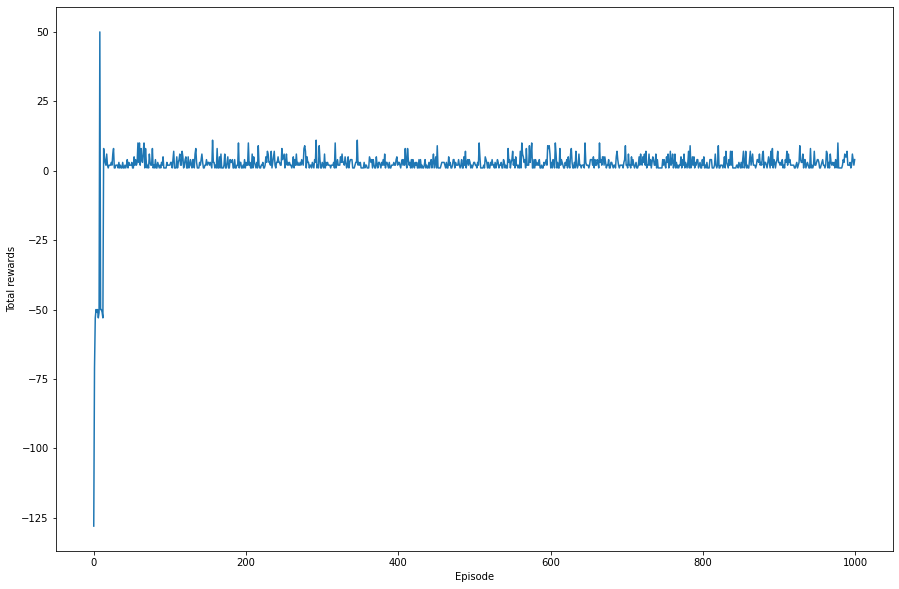

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

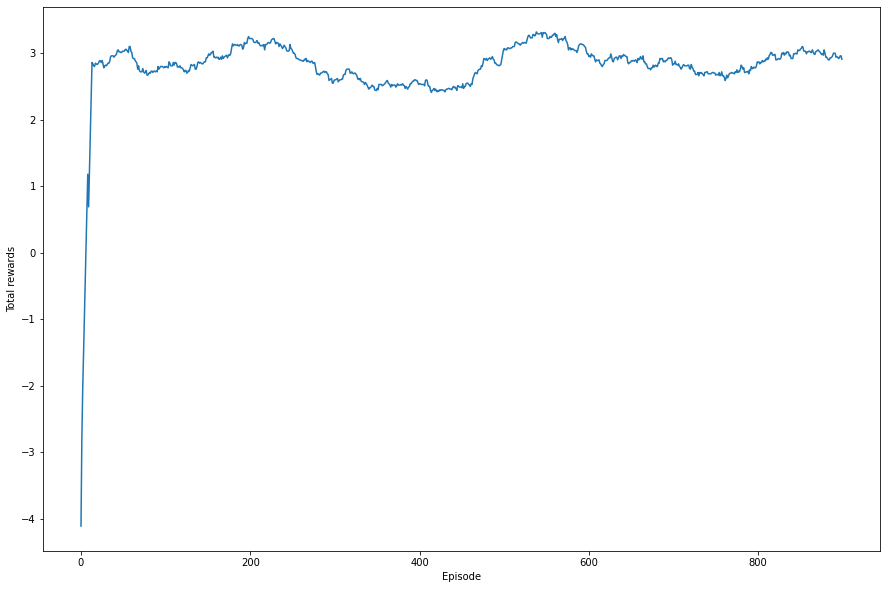

In [12]:
average_number=100
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

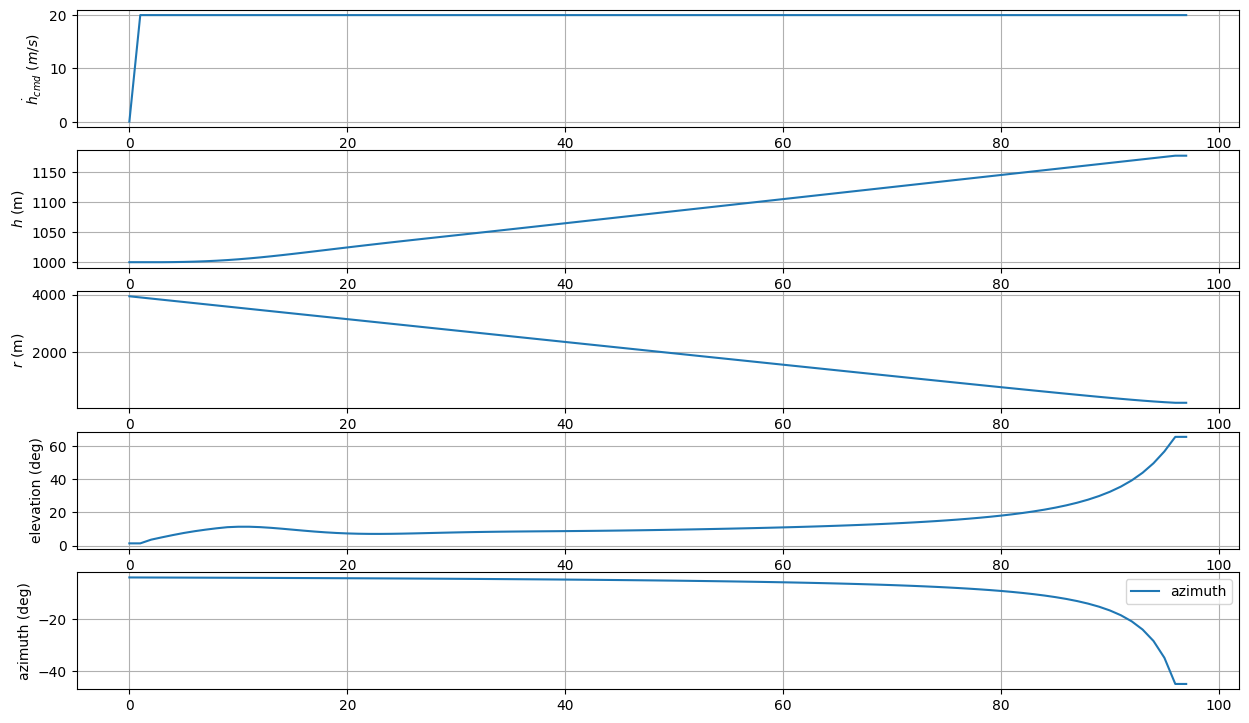

In [16]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

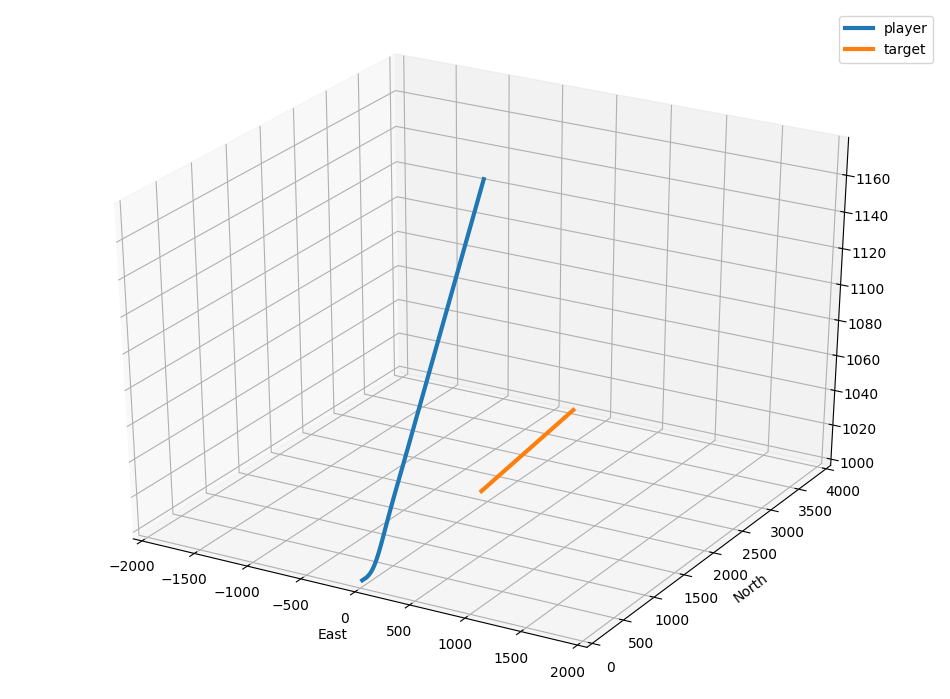

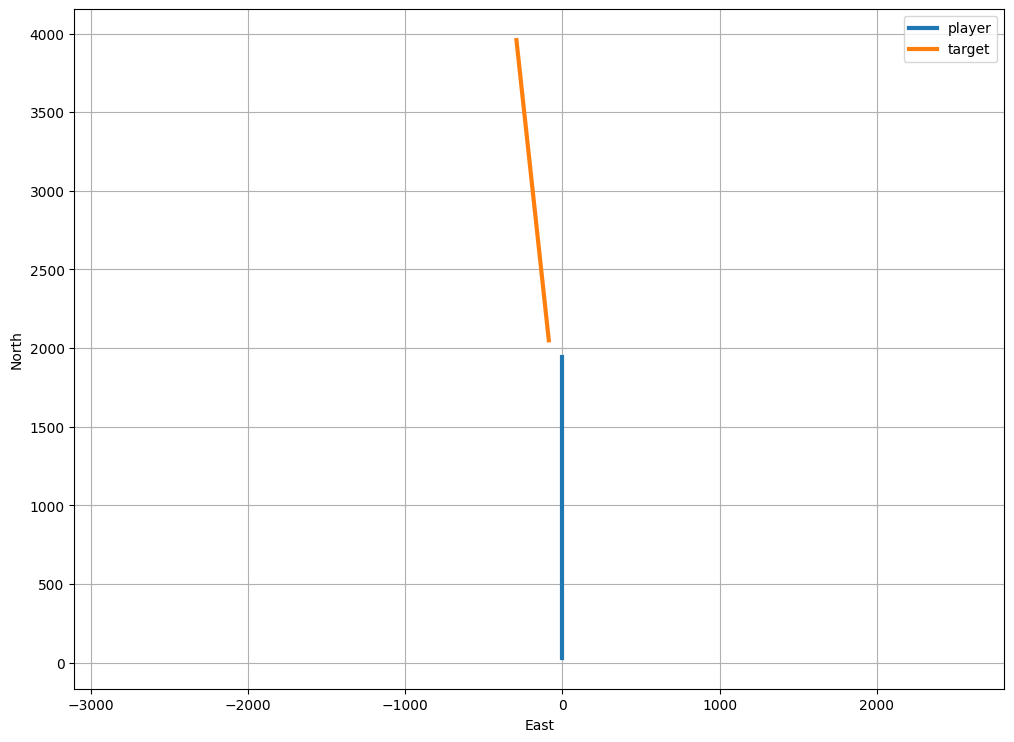

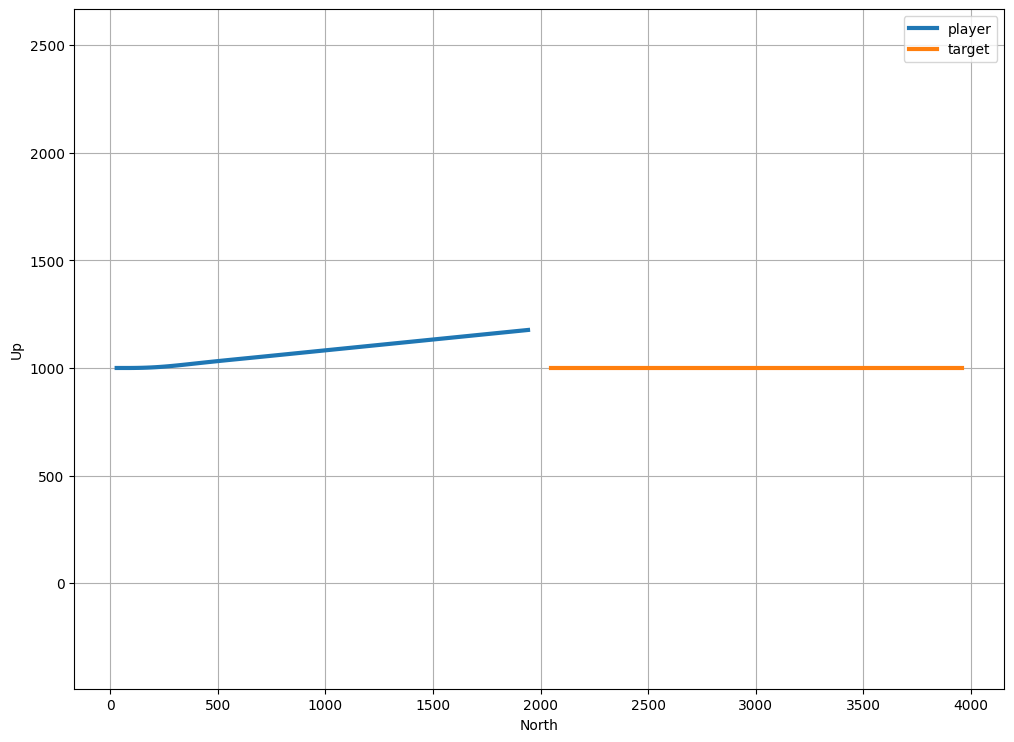

In [17]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()